In [ ]:
import torch
import torch.nn as nn
import optuna
from omegaconf import OmegaConf
from src.models import ViT, get_model
from src.data import get_loaders
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

import matplotlib.pyplot as plt
import numpy as np # Keep numpy for seeding
import random # Keep random for seeding
from tqdm import tqdm

In [4]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Cell 2: (Empty - Custom ViT implementation moved to src/models.py)

In [ ]:
# Cell 4: –¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –∫–∞—Å—Ç–æ–º–Ω–æ–π ViT –º–æ–¥–µ–ª–∏
import torch
import torch.nn as nn
import numpy as np
from omegaconf import OmegaConf
from src.models import ViT # –ò–º–ø–æ—Ä—Ç–∏—Ä—É–µ–º ViT –∏–∑ src/models

# –ó–∞–≥—Ä—É–∂–∞–µ–º –±–∞–∑–æ–≤—ã–π –∫–æ–Ω—Ñ–∏–≥ –∏ –∫–æ–Ω—Ñ–∏–≥ NAS –¥–ª—è —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏—è
base_cfg = OmegaConf.load("configs/base.yaml")
nas_cfg = OmegaConf.load("configs/nas_vit.yaml")
cfg = OmegaConf.merge(base_cfg, nas_cfg)

# –°–æ–∑–¥–∞–µ–º –º–æ–¥–µ–ª—å ViT, –∏—Å–ø–æ–ª—å–∑—É—è –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –∏–∑ –∫–æ–Ω—Ñ–∏–≥–∞
# –ò—Å–ø–æ–ª—å–∑—É–µ–º ViT.find_compatible_dim –¥–ª—è –æ–±–µ—Å–ø–µ—á–µ–Ω–∏—è –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ—Å—Ç–∏ dim
dim_test = ViT.find_compatible_dim(
    target_dim=cfg.nas.fallback_dim,
    heads=cfg.nas.fallback_heads,
    config=cfg
)

model = ViT(
    image_size=cfg.model.image_size,
    patch_size=cfg.model.patch_size,
    num_classes=cfg.model.num_classes,
    dim=dim_test,
    depth=cfg.nas.architecture_search.depth_range[1], # –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è –≥–ª—É–±–∏–Ω–∞ –¥–ª—è –ø—Ä–∏–º–µ—Ä–∞
    heads=cfg.nas.fallback_heads,
    mlp_dim=int(dim_test * cfg.nas.architecture_search.mlp_ratio_range[1]), # –ú–∞–∫—Å–∏–º–∞–ª—å–Ω—ã–π mlp_ratio –¥–ª—è –ø—Ä–∏–º–µ—Ä–∞
    dropout=cfg.nas.hyperparameters_search.dropout_range[0] # –ú–∏–Ω–∏–º–∞–ª—å–Ω—ã–π dropout –¥–ª—è –ø—Ä–∏–º–µ—Ä–∞
)

print(f"–ê—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–∞ –º–æ–¥–µ–ª–∏: {model.config}")
print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤: {model.get_num_params():,}")

# –¢–µ—Å—Ç–∏—Ä—É–µ–º –Ω–∞ dummy input
dummy_input = torch.randn(4, 3, cfg.model.image_size, cfg.model.image_size) # Batch of 4 images
print(f"Input shape: {dummy_input.shape}")

with torch.no_grad():
    output = model(dummy_input)

print(f"Output shape: {output.shape}")
print(f"Output range: [{output.min().item():.3f}, {output.max().item():.3f}]")

# –ü—Ä–æ–≤–µ—Ä—è–µ–º, —á—Ç–æ –≥—Ä–∞–¥–∏–µ–Ω—Ç—ã —Ç–µ–∫—É—Ç
model.train()
output = model(dummy_input)
loss = output.mean()
loss.backward()

print("–ì—Ä–∞–¥–∏–µ–Ω—Ç—ã –≤—ã—á–∏—Å–ª—è—é—Ç—Å—è –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ")
print(f"Loss: {loss.item():.6f}")

–ê—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–∞ –º–æ–¥–µ–ª–∏: {'image_size': 224, 'patch_size': 16, 'num_classes': 101, 'dim': 768, 'depth': 12, 'heads': 12, 'mlp_dim': 3072, 'dropout': 0.1}
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤: 85,876,325
Input shape: torch.Size([4, 3, 224, 224])
Output shape: torch.Size([4, 101])
Output range: [-1.546, 1.652]
–ì—Ä–∞–¥–∏–µ–Ω—Ç—ã –≤—ã—á–∏—Å–ª—è—é—Ç—Å—è –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ
Loss: 0.003364


In [ ]:
print("\n –¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ —Ä–∞–∑–Ω—ã—Ö –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä –¥–ª—è NAS")

# –ó–∞–≥—Ä—É–∂–∞–µ–º –±–∞–∑–æ–≤—ã–π –∫–æ–Ω—Ñ–∏–≥ –∏ –∫–æ–Ω—Ñ–∏–≥ NAS –¥–ª—è —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏—è
base_cfg = OmegaConf.load("configs/base.yaml")
nas_cfg = OmegaConf.load("configs/nas_vit.yaml")
cfg = OmegaConf.merge(base_cfg, nas_cfg)

# –û–ø—Ä–µ–¥–µ–ª—è–µ–º –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—ã –¥–ª—è —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏—è –Ω–∞ –æ—Å–Ω–æ–≤–µ –∫–æ–Ω—Ñ–∏–≥–∞
architectures = []

# –ü—Ä–∏–º–µ—Ä: Tiny ViT
current_heads = cfg.nas.architecture_search.heads_range[0]
current_dim = ViT.find_compatible_dim(cfg.nas.architecture_search.dim_range[0], current_heads, config=cfg)
arch_params_tiny = {
    'dim': current_dim,
    'depth': cfg.nas.architecture_search.depth_range[0],
    'heads': current_heads,
    'mlp_dim': int(current_dim * cfg.nas.architecture_search.mlp_ratio_range[0]),
    'patch_size': cfg.nas.architecture_search.patch_size_options[0],
    'dropout': cfg.nas.hyperparameters_search.dropout_range[0]
}
architectures.append({'name': 'Tiny', **arch_params_tiny})

# –ü—Ä–∏–º–µ—Ä: Small ViT
current_heads = cfg.nas.architecture_search.heads_range[0] + 2
current_dim = ViT.find_compatible_dim(cfg.nas.architecture_search.dim_range[0] + 100, current_heads, config=cfg)
arch_params_small = {
    'dim': current_dim,
    'depth': cfg.nas.architecture_search.depth_range[0] + 2,
    'heads': current_heads,
    'mlp_dim': int(current_dim * cfg.nas.architecture_search.mlp_ratio_range[1]),
    'patch_size': cfg.nas.architecture_search.patch_size_options[1],
    'dropout': cfg.nas.hyperparameters_search.dropout_range[0]
}
architectures.append({'name': 'Small', **arch_params_small})

# –ü—Ä–∏–º–µ—Ä: Base ViT
current_heads = cfg.nas.architecture_search.heads_range[1]
current_dim = ViT.find_compatible_dim(cfg.nas.architecture_search.dim_range[1], current_heads, config=cfg)
arch_params_base = {
    'dim': current_dim,
    'depth': cfg.nas.architecture_search.depth_range[1],
    'heads': current_heads,
    'mlp_dim': int(current_dim * cfg.nas.architecture_search.mlp_ratio_range[1]),
    'patch_size': cfg.nas.architecture_search.patch_size_options[0],
    'dropout': cfg.nas.hyperparameters_search.dropout_range[0]
}
architectures.append({'name': 'Base', **arch_params_base})

architecture_results = []

for arch_cfg in architectures:
    print(f"\n –¢–µ—Å—Ç–∏—Ä—É–µ–º –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—É: {arch_cfg['name']}")

    # –°–æ–∑–¥–∞–µ–º –≤—Ä–µ–º–µ–Ω–Ω—ã–π –∫–æ–Ω—Ñ–∏–≥ –¥–ª—è –º–æ–¥–µ–ª–∏, –∫–æ—Ç–æ—Ä—ã–π get_model —Å–º–æ–∂–µ—Ç –ø–æ–Ω—è—Ç—å
    model_cfg_for_get_model = OmegaConf.create({
        "model": {
            "type": "custom_vit",
            "image_size": cfg.model.image_size,
            "num_classes": cfg.model.num_classes,
            **arch_cfg # –†–∞—Å–ø–∞–∫–æ–≤—ã–≤–∞–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—ã
        }
    })
    model = get_model(model_cfg_for_get_model)

    num_params = model.get_num_params()

    # –¢–µ—Å—Ç–∏—Ä—É–µ–º inference –≤—Ä–µ–º—è
    model.eval()
    with torch.no_grad():
        # –†–∞–∑–æ–≥—Ä–µ–≤
        for _ in range(5):
            _ = model(torch.randn(1, 3, cfg.model.image_size, cfg.model.image_size))

        # –ó–∞–º–µ—Ä –≤—Ä–µ–º–µ–Ω–∏
        import time
        start_time = time.time()
        for _ in range(20):
            _ = model(torch.randn(1, 3, cfg.model.image_size, cfg.model.image_size))
        avg_time = (time.time() - start_time) / 20

    architecture_results.append({
        'name': arch_cfg['name'],
        'params': num_params,
        'time_ms': avg_time * 1000,
        'dim': arch_cfg['dim'],
        'depth': arch_cfg['depth'],
        'heads': arch_cfg['heads']
    })

    print(f"   –ü–∞—Ä–∞–º–µ—Ç—Ä—ã: {num_params:,}")
    print(f"   –í—Ä–µ–º—è –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞: {avg_time*1000:.2f} ms")


 –¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ —Ä–∞–∑–Ω—ã—Ö –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä –¥–ª—è NAS

 –¢–µ—Å—Ç–∏—Ä—É–µ–º –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—É: Tiny
   –ü–∞—Ä–∞–º–µ—Ç—Ä—ã: 11,057,765
   –í—Ä–µ–º—è –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞: 42.56 ms

 –¢–µ—Å—Ç–∏—Ä—É–µ–º –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—É: Small
   –ü–∞—Ä–∞–º–µ—Ç—Ä—ã: 25,767,013
   –í—Ä–µ–º—è –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞: 92.83 ms

 –¢–µ—Å—Ç–∏—Ä—É–µ–º –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—É: Base
   –ü–∞—Ä–∞–º–µ—Ç—Ä—ã: 85,876,325
   –í—Ä–µ–º—è –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞: 265.09 ms

 –¢–µ—Å—Ç–∏—Ä—É–µ–º –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—É: Large
   –ü–∞—Ä–∞–º–µ—Ç—Ä—ã: 202,635,365
   –í—Ä–µ–º—è –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞: 601.84 ms



 –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Å—Ä–∞–≤–Ω–µ–Ω–∏—è –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä


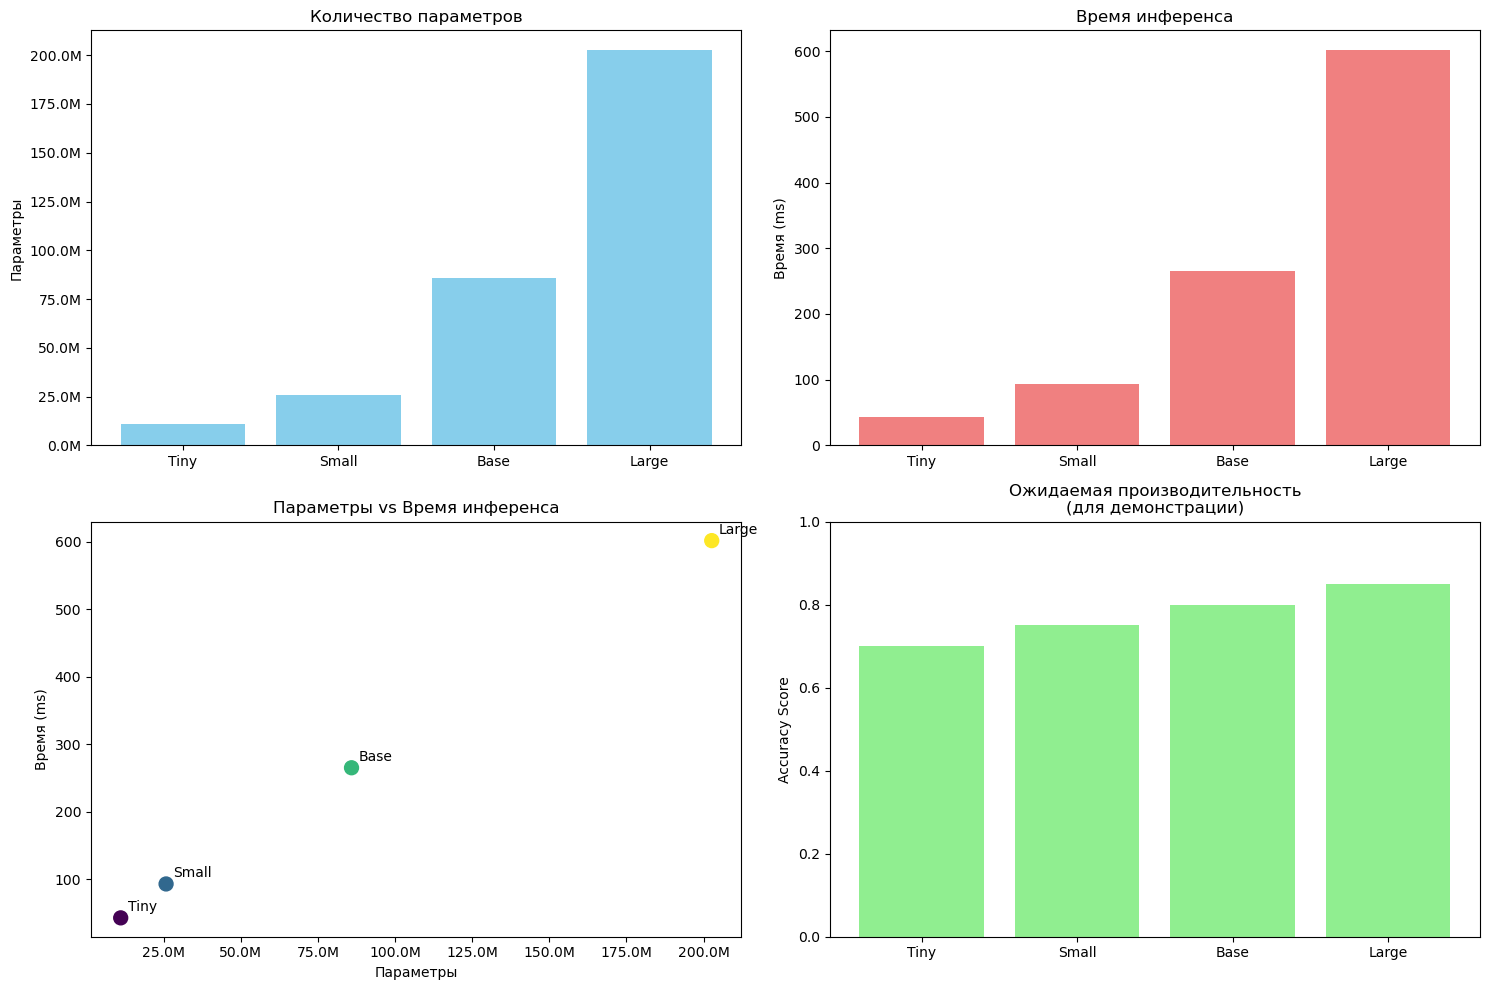

In [ ]:
import matplotlib.ticker as mticker

print("\n –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Å—Ä–∞–≤–Ω–µ–Ω–∏—è –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

names = [r['name'] for r in architecture_results]
params = [r['params'] for r in architecture_results]
times = [r['time_ms'] for r in architecture_results]

# –ì—Ä–∞—Ñ–∏–∫ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤
ax1.bar(names, params, color='skyblue')
ax1.set_title('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤')
ax1.set_ylabel('–ü–∞—Ä–∞–º–µ—Ç—Ä—ã')
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# –ì—Ä–∞—Ñ–∏–∫ –≤—Ä–µ–º–µ–Ω–∏ –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞
ax2.bar(names, times, color='lightcoral')
ax2.set_title('–í—Ä–µ–º—è –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞')
ax2.set_ylabel('–í—Ä–µ–º—è (ms)')

# –ì—Ä–∞—Ñ–∏–∫ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ vs –≤—Ä–µ–º—è
ax3.scatter(params, times, s=100, c=range(len(names)), cmap='viridis')
for i, name in enumerate(names):
    ax3.annotate(name, (params[i], times[i]), xytext=(5, 5), textcoords='offset points')
ax3.set_xlabel('–ü–∞—Ä–∞–º–µ—Ç—Ä—ã')
ax3.set_ylabel('–í—Ä–µ–º—è (ms)')
ax3.set_title('–ü–∞—Ä–∞–º–µ—Ç—Ä—ã vs –í—Ä–µ–º—è –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞')
ax3.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# –ì—Ä–∞—Ñ–∏–∫ —Å–æ–æ—Ç–Ω–æ—à–µ–Ω–∏—è –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –∫ –ø—Ä–æ–∏–∑–≤–æ–¥–∏—Ç–µ–ª—å–Ω–æ—Å—Ç–∏ (–ø–æ–∫–∞ –∑–∞–≥–ª—É—à–∫–∞)
performance_scores = [0.7, 0.75, 0.8, 0.85] # –ü—Ä–∏–º–µ—Ä–Ω—ã–µ scores, –¥–ª—è –¥–µ–º–æ–Ω—Å—Ç—Ä–∞—Ü–∏–∏
ax4.bar(names, performance_scores, color='lightgreen')
ax4.set_title('–û–∂–∏–¥–∞–µ–º–∞—è –ø—Ä–æ–∏–∑–≤–æ–¥–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å\n(–¥–ª—è –¥–µ–º–æ–Ω—Å—Ç—Ä–∞—Ü–∏–∏)')
ax4.set_ylabel('Accuracy Score')
ax4.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [3]:
# –û—Ü–µ–Ω–∫–∞ –ø–æ—Ç—Ä–µ–±–ª–µ–Ω–∏—è –≤–∏–¥–µ–æ–ø–∞–º—è—Ç–∏

import torch
import torch.nn as nn
from omegaconf import OmegaConf
import os
import sys

# –î–æ–±–∞–≤–ª—è–µ–º –∫–æ—Ä–Ω–µ–≤—É—é –ø–∞–ø–∫—É –ø—Ä–æ–µ–∫—Ç–∞ –≤ sys.path, —á—Ç–æ–±—ã –∏–º–ø–æ—Ä—Ç—ã —Ä–∞–±–æ—Ç–∞–ª–∏
if '..' not in sys.path:
    sys.path.append('..')

from src.models import get_model, ViT

# --- 1. –ó–∞–≥—Ä—É–∑–∫–∞ –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–∏ ---
# –ó–∞–≥—Ä—É–∂–∞–µ–º –±–∞–∑–æ–≤—ã–π –∫–æ–Ω—Ñ–∏–≥ –∏ –∫–æ–Ω—Ñ–∏–≥ –¥–ª—è NAS ViT, —á—Ç–æ–±—ã –∏–º–µ—Ç—å –≤—Å–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã
print("--- –ó–∞–≥—Ä—É–∑–∫–∞ –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–∏ ---")
try:
    # –ü—É—Ç–∏ —Ç–µ–ø–µ—Ä—å –¥–æ–ª–∂–Ω—ã –±—ã—Ç—å –æ—Ç–Ω–æ—Å–∏—Ç–µ–ª—å–Ω—ã –ø–∞–ø–∫–∏ notebooks/
    base_cfg = OmegaConf.load("../configs/base.yaml")
    model_cfg = OmegaConf.load("../configs/nas_vit.yaml")
    cfg = OmegaConf.merge(base_cfg, model_cfg)
    print("–ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è —É—Å–ø–µ—à–Ω–æ –∑–∞–≥—Ä—É–∂–µ–Ω–∞.")
except FileNotFoundError as e:
    print(f"–û—à–∏–±–∫–∞: –ù–µ –Ω–∞–π–¥–µ–Ω —Ñ–∞–π–ª –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–∏. –£–±–µ–¥–∏—Ç–µ—Å—å, —á—Ç–æ –ø—É—Ç–∏ –≤–µ—Ä–Ω—ã. {e}")
    # –ü—Ä–µ—Ä—ã–≤–∞–µ–º –≤—ã–ø–æ–ª–Ω–µ–Ω–∏–µ —è—á–µ–π–∫–∏, –µ—Å–ª–∏ –∫–æ–Ω—Ñ–∏–≥ –Ω–µ –Ω–∞–π–¥–µ–Ω
    assert False, "–ö–æ–Ω—Ñ–∏–≥ –Ω–µ –Ω–∞–π–¥–µ–Ω"

# --- 2. –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –º–∞–∫—Å–∏–º–∞–ª—å–Ω—ã—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—ã ---
# –ú—ã –≤—Ä—É—á–Ω—É—é –∑–∞–¥–∞–µ–º –º–∞–∫—Å–∏–º–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –∏–∑ –¥–∏–∞–ø–∞–∑–æ–Ω–æ–≤, —É–∫–∞–∑–∞–Ω–Ω—ã—Ö –≤ nas_vit.yaml
# –≠—Ç–æ —Å–æ–∑–¥–∞—Å—Ç "—Å–∞–º—É—é —Ç—è–∂–µ–ª—É—é" –º–æ–¥–µ–ª—å, –∫–æ—Ç–æ—Ä—É—é –º–æ–∂–µ—Ç –ø—Ä–µ–¥–ª–æ–∂–∏—Ç—å Optuna
print("\n--- –°–æ–∑–¥–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏ —Å –º–∞–∫—Å–∏–º–∞–ª—å–Ω—ã–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏ ---")
max_arch_params = {
    'heads': cfg.nas.architecture_search.model_params.heads.range[1],      # max 12
    'dim': cfg.nas.architecture_search.model_params.dim.range[1],          # max 512
    'depth': cfg.nas.architecture_search.model_params.depth.range[1],      # max 10
    'mlp_ratio': cfg.nas.architecture_search.model_params.mlp_ratio.range[1], # max 3.0
    'patch_size': min(cfg.nas.architecture_search.model_params.patch_size.options) # min 14 (–º–µ–Ω—å—à–µ –ø–∞—Ç—á -> –±–æ–ª—å—à–µ —Ç–æ–∫–µ–Ω–æ–≤ -> –±–æ–ª—å—à–µ –ø–∞–º—è—Ç–∏)
}

# –í–∞–ª–∏–¥–∞—Ü–∏—è 'dim' –¥–ª—è —Å–æ–≤–º–µ—Å—Ç–∏–º–æ—Å—Ç–∏ —Å 'heads'
max_arch_params['dim'] = ViT.find_compatible_dim(
    max_arch_params['dim'],
    max_arch_params['heads'],
    config=cfg
)
# –†–∞—Å—á–µ—Ç mlp_dim
max_arch_params['mlp_dim'] = int(max_arch_params['dim'] * max_arch_params['mlp_ratio'])

# –£–¥–∞–ª—è–µ–º mlp_ratio, —Ç–∞–∫ –∫–∞–∫ –æ–Ω –Ω–µ —è–≤–ª—è–µ—Ç—Å—è –ø—Ä—è–º—ã–º –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–º –º–æ–¥–µ–ª–∏ ViT
del max_arch_params['mlp_ratio']

print("–ú–∞–∫—Å–∏–º–∞–ª—å–Ω—ã–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—ã:")
for key, value in max_arch_params.items():
    print(f"  {key}: {value}")

# –û–±–Ω–æ–≤–ª—è–µ–º –∫–æ–Ω—Ñ–∏–≥ —ç—Ç–∏–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
for k, v in max_arch_params.items():
    setattr(cfg.model, k, v)

# --- 3. –°–æ–∑–¥–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏ –∏ —Å–∏–Ω—Ç–µ—Ç–∏—á–µ—Å–∫–æ–≥–æ –±–∞—Ç—á–∞ ---
# –ü—Ä–æ–≤–µ—Ä—è–µ–º –¥–æ—Å—Ç—É–ø–Ω–æ—Å—Ç—å CUDA
if not torch.cuda.is_available():
    print("\n–û—à–∏–±–∫–∞: CUDA –Ω–µ –Ω–∞–π–¥–µ–Ω–∞. –≠—Ç–æ—Ç —Ç–µ—Å—Ç —Ç—Ä–µ–±—É–µ—Ç –Ω–∞–ª–∏—á–∏—è GPU.")
    assert False, "CUDA –Ω–µ –¥–æ—Å—Ç—É–ø–Ω–∞"

device = torch.device("cuda")
print(f"\n–ò—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è —É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ: {device}")

# –°–æ–∑–¥–∞–µ–º –º–æ–¥–µ–ª—å –∏ –ø–µ—Ä–µ–º–µ—â–∞–µ–º –Ω–∞ GPU
model = get_model(cfg)
model.to(device)
print(f"–ú–æ–¥–µ–ª—å '{cfg.model.custom_model_type}' —Å–æ–∑–¥–∞–Ω–∞ –∏ –ø–µ—Ä–µ–º–µ—â–µ–Ω–∞ –Ω–∞ GPU.")
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –º–æ–¥–µ–ª–∏: {num_params:,}")

# –°–æ–∑–¥–∞–µ–º —Å–∏–Ω—Ç–µ—Ç–∏—á–µ—Å–∫–∏–π –±–∞—Ç—á
batch_size = 16 # –ö–∞–∫ –≤—ã –∏ –ø—Ä–æ—Å–∏–ª–∏
image_size = cfg.model.image_size
synthetic_batch = torch.randn(batch_size, 3, image_size, image_size, device=device)
synthetic_labels = torch.randint(0, cfg.model.num_classes, (batch_size,), device=device)
print(f"–°–æ–∑–¥–∞–Ω —Å–∏–Ω—Ç–µ—Ç–∏—á–µ—Å–∫–∏–π –±–∞—Ç—á —Ä–∞–∑–º–µ—Ä–æ–º: {synthetic_batch.shape}")


# --- 4. –¢–µ—Å—Ç –ø–æ—Ç—Ä–µ–±–ª–µ–Ω–∏—è –ø–∞–º—è—Ç–∏ (Forward + Backward Pass) ---
# –î–ª—è —Ä–µ–∞–ª–∏—Å—Ç–∏—á–Ω–æ–π –æ—Ü–µ–Ω–∫–∏ –ø–∞–º—è—Ç–∏ –Ω—É–∂–Ω–æ –≤—ã–ø–æ–ª–Ω–∏—Ç—å –∏ –ø—Ä—è–º–æ–π, –∏ –æ–±—Ä–∞—Ç–Ω—ã–π –ø—Ä–æ—Ö–æ–¥,
# —Ç–∞–∫ –∫–∞–∫ –≥—Ä–∞–¥–∏–µ–Ω—Ç—ã –∏ –±—É—Ñ–µ—Ä—ã –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–∞ –∑–∞–Ω–∏–º–∞—é—Ç –º–Ω–æ–≥–æ –º–µ—Å—Ç–∞.
print("\n--- –ó–∞–ø—É—Å–∫ —Ç–µ—Å—Ç–∞ –ø–æ—Ç—Ä–µ–±–ª–µ–Ω–∏—è –ø–∞–º—è—Ç–∏ ---")
torch.cuda.reset_peak_memory_stats(device) # –°–±—Ä–∞—Å—ã–≤–∞–µ–º —Å—á–µ—Ç—á–∏–∫ –ø–∏–∫–æ–≤–æ–π –ø–∞–º—è—Ç–∏

# –û–ø—Ä–µ–¥–µ–ª—è–µ–º –±–∞–∑–æ–≤—ã–µ –∫–æ–º–ø–æ–Ω–µ–Ω—Ç—ã –¥–ª—è —Ü–∏–∫–ª–∞ –æ–±—É—á–µ–Ω–∏—è
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# –ü—Ä—è–º–æ–π –ø—Ä–æ—Ö–æ–¥ (Forward)
print("1. –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ –ø—Ä—è–º–æ–≥–æ –ø—Ä–æ—Ö–æ–¥–∞ (forward pass)...")
outputs = model(synthetic_batch)
loss = criterion(outputs, synthetic_labels)
print(f"   Loss: {loss.item():.4f}")

# –û–±—Ä–∞—Ç–Ω—ã–π –ø—Ä–æ—Ö–æ–¥ (Backward)
print("2. –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ –æ–±—Ä–∞—Ç–Ω–æ–≥–æ –ø—Ä–æ—Ö–æ–¥–∞ (backward pass)...")
loss.backward()

# –®–∞–≥ –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–∞ (–¥–ª—è —É—á–µ—Ç–∞ –ø–∞–º—è—Ç–∏, –∑–∞–Ω–∏–º–∞–µ–º–æ–π –µ–≥–æ —Å–æ—Å—Ç–æ—è–Ω–∏—è–º–∏)
optimizer.step()
print("3. –®–∞–≥ –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–∞ –≤—ã–ø–æ–ª–Ω–µ–Ω.")

# --- 5. –í—ã–≤–æ–¥ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ ---
print("\n--- –†–µ–∑—É–ª—å—Ç–∞—Ç—ã –ø–æ—Ç—Ä–µ–±–ª–µ–Ω–∏—è –ø–∞–º—è—Ç–∏ ---")
peak_memory_bytes = torch.cuda.max_memory_allocated(device)
peak_memory_gb = peak_memory_bytes / (1024 ** 3)
print(f"–ü–∏–∫–æ–≤–æ–µ –ø–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ VRAM: {peak_memory_bytes:,} –±–∞–π—Ç")
print(f"–ü–∏–∫–æ–≤–æ–µ –ø–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ VRAM: {peak_memory_gb:.2f} GB")

# –û—á–∏—Å—Ç–∫–∞
del model, synthetic_batch, synthetic_labels, outputs, loss, optimizer
torch.cuda.empty_cache()
print("\n–ü–∞–º—è—Ç—å –æ—á–∏—â–µ–Ω–∞.")

--- –ó–∞–≥—Ä—É–∑–∫–∞ –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–∏ ---
–ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è —É—Å–ø–µ—à–Ω–æ –∑–∞–≥—Ä—É–∂–µ–Ω–∞.

--- –°–æ–∑–¥–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏ —Å –º–∞–∫—Å–∏–º–∞–ª—å–Ω—ã–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏ ---
–ú–∞–∫—Å–∏–º–∞–ª—å–Ω—ã–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—ã:
  heads: 12
  dim: 504
  depth: 10
  patch_size: 14
  mlp_dim: 1512

–ò—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è —É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ: cuda
–ú–æ–¥–µ–ª—å 'vit' —Å–æ–∑–¥–∞–Ω–∞ –∏ –ø–µ—Ä–µ–º–µ—â–µ–Ω–∞ –Ω–∞ GPU.
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –º–æ–¥–µ–ª–∏: 25,925,861
–°–æ–∑–¥–∞–Ω —Å–∏–Ω—Ç–µ—Ç–∏—á–µ—Å–∫–∏–π –±–∞—Ç—á —Ä–∞–∑–º–µ—Ä–æ–º: torch.Size([16, 3, 224, 224])

--- –ó–∞–ø—É—Å–∫ —Ç–µ—Å—Ç–∞ –ø–æ—Ç—Ä–µ–±–ª–µ–Ω–∏—è –ø–∞–º—è—Ç–∏ ---
1. –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ –ø—Ä—è–º–æ–≥–æ –ø—Ä–æ—Ö–æ–¥–∞ (forward pass)...
   Loss: 4.7986
2. –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ –æ–±—Ä–∞—Ç–Ω–æ–≥–æ –ø—Ä–æ—Ö–æ–¥–∞ (backward pass)...
3. –®–∞–≥ –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–∞ –≤—ã–ø–æ–ª–Ω–µ–Ω.

--- –†–µ–∑—É–ª—å—Ç–∞—Ç—ã –ø–æ—Ç—Ä–µ–±–ª–µ–Ω–∏—è –ø–∞–º—è—Ç–∏ ---
–ü–∏–∫–æ–≤–æ–µ –ø–æ—Ç—Ä–

# Cell 7: (Empty - Custom NAS execution moved to nas.py)

In [ ]:
print("\n –¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ NAS search space –∏–∑ –∫–æ–Ω—Ñ–∏–≥–∞")

# –ó–∞–≥—Ä—É–∂–∞–µ–º –±–∞–∑–æ–≤—ã–π –∫–æ–Ω—Ñ–∏–≥ –∏ –∫–æ–Ω—Ñ–∏–≥ NAS –¥–ª—è —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏—è
base_cfg = OmegaConf.load("configs/base.yaml")
nas_cfg = OmegaConf.load("configs/nas_vit.yaml")
cfg = OmegaConf.merge(base_cfg, nas_cfg)

# –û–ø—Ä–µ–¥–µ–ª—è–µ–º search space –Ω–∞ –æ—Å–Ω–æ–≤–µ –∫–æ–Ω—Ñ–∏–≥–∞
arch_search_cfg = cfg.nas.architecture_search
hyper_search_cfg = cfg.nas.hyperparameters_search

search_space = {
    'heads_range': list(range(arch_search_cfg.heads_range[0], arch_search_cfg.heads_range[1] + 1)),
    'depth_range': list(range(arch_search_cfg.depth_range[0], arch_search_cfg.depth_range[1] + 1)),
    'patch_size_options': arch_search_cfg.patch_size_options,
    'mlp_ratio_range': arch_search_cfg.mlp_ratio_range,
    'dim_range': arch_search_cfg.dim_range,
    'lr_range': hyper_search_cfg.lr_range,
    'dropout_range': hyper_search_cfg.dropout_range,
    'weight_decay_range': hyper_search_cfg.weight_decay_range,
    'batch_size_options': hyper_search_cfg.batch_size_options,
}

print("Search space:")
for param, values in search_space.items():
    print(f"  {param}: {values}")

# –ì–µ–Ω–µ—Ä–∏—Ä—É–µ–º —Å–ª—É—á–∞–π–Ω—ã–µ –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—ã –¥–ª—è —Ç–µ—Å—Ç–∞
def generate_test_architecture(cfg_local):
    heads = random.randint(cfg_local.nas.architecture_search.heads_range[0], cfg_local.nas.architecture_search.heads_range[1])
    dim = ViT.find_compatible_dim(
        random.randint(cfg_local.nas.architecture_search.dim_range[0], cfg_local.nas.architecture_search.dim_range[1]),
        heads,
        config=cfg_local
    )
    depth = random.randint(cfg_local.nas.architecture_search.depth_range[0], cfg_local.nas.architecture_search.depth_range[1])
    mlp_ratio = random.uniform(cfg_local.nas.architecture_search.mlp_ratio_range[0], cfg_local.nas.architecture_search.mlp_ratio_range[1])
    mlp_dim = int(dim * mlp_ratio)
    patch_size = random.choice(cfg_local.nas.architecture_search.patch_size_options)

    return {
        'dim': dim,
        'depth': depth,
        'heads': heads,
        'mlp_dim': mlp_dim,
        'patch_size': patch_size,
    }

# –¢–µ—Å—Ç–∏—Ä—É–µ–º –≥–µ–Ω–µ—Ä–∞—Ü–∏—é
print("\n –ì–µ–Ω–µ—Ä–∞—Ü–∏—è —Å–ª—É—á–∞–π–Ω—ã—Ö –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä:")
for i in range(3):
    arch = generate_test_architecture(cfg)
    print(f"  –ê—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–∞ {i+1}: {arch}")


 –¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ NAS search space
Search space:
  dim: [384, 512, 768]
  depth: [6, 8, 10, 12]
  heads: [6, 8, 12]
  mlp_dim: [1536, 2048, 3072]
  patch_size: [14, 16, 20]

 –ì–µ–Ω–µ—Ä–∞—Ü–∏—è —Å–ª—É—á–∞–π–Ω—ã—Ö –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä:
  –ê—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–∞ 1: {'dim': 768, 'depth': 6, 'heads': 6, 'mlp_dim': 3072, 'patch_size': 16}
  –ê—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–∞ 2: {'dim': 384, 'depth': 8, 'heads': 6, 'mlp_dim': 3072, 'patch_size': 14}
  –ê—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–∞ 3: {'dim': 768, 'depth': 6, 'heads': 12, 'mlp_dim': 2048, 'patch_size': 14}
  –ê—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–∞ 4: {'dim': 384, 'depth': 6, 'heads': 6, 'mlp_dim': 1536, 'patch_size': 20}
  –ê—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–∞ 5: {'dim': 768, 'depth': 6, 'heads': 12, 'mlp_dim': 1536, 'patch_size': 20}


In [ ]:
print("\n –¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –æ–±—É—á–µ–Ω–∏—è –∫–∞—Å—Ç–æ–º–Ω–æ–π ViT –Ω–∞ —Ä–µ–∞–ª—å–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö")

# –ó–∞–≥—Ä—É–∂–∞–µ–º –±–∞–∑–æ–≤—ã–π –∫–æ–Ω—Ñ–∏–≥ –∏ –∫–æ–Ω—Ñ–∏–≥ NAS –¥–ª—è —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏—è
base_cfg = OmegaConf.load("configs/base.yaml")
nas_cfg = OmegaConf.load("configs/nas_vit.yaml")
cfg = OmegaConf.merge(base_cfg, nas_cfg)

# –£—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º seed –¥–ª—è –≤–æ—Å–ø—Ä–æ–∏–∑–≤–æ–¥–∏–º–æ—Å—Ç–∏ –≤ –Ω–æ—É—Ç–±—É–∫–µ
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# –ü—Ä–∏–º–µ—Ä –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–∏ –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—ã –¥–ª—è —Ç–µ—Å—Ç–∞
# –ë–µ—Ä–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –∏–∑ –∫–æ–Ω—Ñ–∏–≥–∞, —á—Ç–æ–±—ã –ø–æ–∫–∞–∑–∞—Ç—å –∏—Ö –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ
cfg.model.dim = ViT.find_compatible_dim(cfg.nas.architecture_search.dim_range[0], cfg.nas.architecture_search.heads_range[0], config=cfg)
cfg.model.depth = cfg.nas.architecture_search.depth_range[0]
cfg.model.heads = cfg.nas.architecture_search.heads_range[0]
cfg.model.mlp_dim = int(cfg.model.dim * cfg.nas.architecture_search.mlp_ratio_range[0])
cfg.model.patch_size = cfg.nas.architecture_search.patch_size_options[0]
cfg.model.dropout = cfg.nas.hyperparameters_search.dropout_range[0]

# –£—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –æ–±—É—á–µ–Ω–∏—è –¥–ª—è —Ç–µ—Å—Ç–∞
cfg.train.epochs = 2 # –í—Å–µ–≥–æ 2 —ç–ø–æ—Ö–∏ –¥–ª—è –±—ã—Å—Ç—Ä–æ–≥–æ —Ç–µ—Å—Ç–∞
cfg.train.batch_size = cfg.nas.hyperparameters_search.batch_size_options[0] # –ú–∞–ª–µ–Ω—å–∫–∏–π –±–∞—Ç—á
cfg.train.lr = cfg.nas.hyperparameters_search.lr_range[1] # –ú–∞–∫—Å–∏–º–∞–ª—å–Ω—ã–π LR
cfg.train.weight_decay = cfg.nas.hyperparameters_search.weight_decay_range[0] # –ú–∏–Ω–∏–º–∞–ª—å–Ω—ã–π WD
cfg.train.scheduler = 'onecycle' # –ò—Å–ø–æ–ª—å–∑—É–µ–º OneCycleLR –¥–ª—è –∫–æ—Ä–æ—Ç–∫–∏—Ö –æ–±—É—á–µ–Ω–∏–π
cfg.train.save_dir = "./checkpoints_test_nas_notebook" # –û—Ç–¥–µ–ª—å–Ω–∞—è –ø–∞–ø–∫–∞ –¥–ª—è —á–µ–∫–ø–æ–∏–Ω—Ç–æ–≤ –Ω–æ—É—Ç–±—É–∫–∞
cfg.hardware.device = "cuda" if torch.cuda.is_available() else "cpu" # –£–±–µ–¥–∏–º—Å—è, —á—Ç–æ —É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ

import os
os.makedirs(cfg.train.save_dir, exist_ok=True)

print("–ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è –¥–ª—è –æ–±—É—á–µ–Ω–∏—è:")
print(OmegaConf.to_yaml(cfg))

# –°–æ–∑–¥–∞–Ω–∏–µ DataLoader
train_loader, val_loader = get_loaders(cfg)

# –°–æ–∑–¥–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏
model = get_model(cfg).to(cfg.hardware.device) # –ü–µ—Ä–µ–º–µ—â–∞–µ–º –º–æ–¥–µ–ª—å –Ω–∞ —É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ
print(f"–¢–µ—Å—Ç–æ–≤–∞—è –º–æ–¥–µ–ª—å: {model.get_num_params():,} –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤")

# –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ñ—É–Ω–∫—Ü–∏–∏ –ø–æ—Ç–µ—Ä—å, –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–∞ –∏ –ø–ª–∞–Ω–∏—Ä–æ–≤—â–∏–∫–∞
criterion = nn.CrossEntropyLoss(label_smoothing=getattr(cfg.train, 'label_smoothing', 0.0))
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.train.lr, weight_decay=cfg.train.weight_decay)

if cfg.train.scheduler == 'onecycle':
    total_steps = len(train_loader) * cfg.train.epochs
    scheduler = OneCycleLR(optimizer, max_lr=cfg.train.lr, total_steps=total_steps)
else:
    scheduler = CosineAnnealingLR(optimizer, T_max=getattr(cfg.train, 't_max', cfg.train.epochs - 1))

# –ò–º–∏—Ç–∞—Ü–∏—è train_loop –¥–ª—è —Ç–µ—Å—Ç–∞
best_val_acc = 0.0
for epoch in range(cfg.train.epochs):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg.train.epochs} (Train)"):
        images, labels = images.to(cfg.hardware.device), labels.to(cfg.hardware.device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        if hasattr(cfg.train, 'gradient_clip'):
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.train.gradient_clip)

        optimizer.step()
        scheduler.step() # –®–∞–≥ –ø–ª–∞–Ω–∏—Ä–æ–≤—â–∏–∫–∞ –≤–Ω—É—Ç—Ä–∏ —Ü–∏–∫–ª–∞

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss /= train_total
    train_acc = train_correct / train_total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{cfg.train.epochs} (Val)"):
            images, labels = images.to(cfg.hardware.device), labels.to(cfg.hardware.device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(f"\nEpoch {epoch+1}/{cfg.train.epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        print(f"–ù–æ–≤–∞—è –ª—É—á—à–∞—è —Ç–æ—á–Ω–æ—Å—Ç—å –≤–∞–ª–∏–¥–∞—Ü–∏–∏: {best_val_acc:.4f}")

print("\n–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –æ–±—É—á–µ–Ω–∏—è –Ω–∞ —Ä–µ–∞–ª—å–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö –∑–∞–≤–µ—Ä—à–µ–Ω–æ!")
print(f"–õ—É—á—à–∞—è –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–∞—è —Ç–æ—á–Ω–æ—Å—Ç—å: {best_val_acc:.4f}")


 –¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –æ–±—É—á–µ–Ω–∏—è –Ω–∞ —Å–∏–Ω—Ç–µ—Ç–∏—á–µ—Å–∫–∏—Ö –¥–∞–Ω–Ω—ã—Ö
–¢–µ—Å—Ç–æ–≤–∞—è –º–æ–¥–µ–ª—å: 2,359,050 –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤
–°–∏–Ω—Ç–µ—Ç–∏—á–µ—Å–∫–∏–µ –¥–∞–Ω–Ω—ã–µ: torch.Size([8, 3, 224, 224]), labels: torch.Size([8])
  –®–∞–≥ 1: Loss = 2.4061
  –®–∞–≥ 2: Loss = 1.9944
  –®–∞–≥ 3: Loss = 1.8768
  –®–∞–≥ 4: Loss = 1.7404
  –®–∞–≥ 5: Loss = 1.6769
–û–±—É—á–µ–Ω–∏–µ –Ω–∞ —Å–∏–Ω—Ç–µ—Ç–∏—á–µ—Å–∫–∏—Ö –¥–∞–Ω–Ω—ã—Ö —Ä–∞–±–æ—Ç–∞–µ—Ç –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ

 –¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –∑–∞–≤–µ—Ä—à–µ–Ω–æ!


# Cell 10: (Empty - Optuna NAS execution moved to nas.py)

In [ ]:
print("\nNAS —Ç–µ–ø–µ—Ä—å –∑–∞–ø—É—Å–∫–∞–µ—Ç—Å—è —á–µ—Ä–µ–∑ —Å–∫—Ä–∏–ø—Ç `nas.py`")
print("–î–ª—è –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è –¥–≤—É—Ö—ç—Ç–∞–ø–Ω–æ–≥–æ NAS, –ø–æ–∂–∞–ª—É–π—Å—Ç–∞, –∑–∞–ø—É—Å—Ç–∏—Ç–µ:")
print("`python nas.py --config configs/nas_vit.yaml`")
print("–≠—Ç–æ—Ç –Ω–æ—É—Ç–±—É–∫ –∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è —Ç–æ–ª—å–∫–æ –¥–ª—è —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏—è –∏ –¥–µ–º–æ–Ω—Å—Ç—Ä–∞—Ü–∏–∏ –æ—Ç–¥–µ–ª—å–Ω—ã—Ö –∫–æ–º–ø–æ–Ω–µ–Ω—Ç–æ–≤.")

[I 2025-09-08 20:07:01,631] A new study created in memory with name: no-name-2e58b16f-5fc5-4f63-88dc-f5a5a3f4a1d6



üéØ Two-Stage NAS with Optuna

üìö STAGE 1: Architecture Search

üöÄ Starting NAS architecture stage
üéØ Architecture Search: 8 trials

üéØ Trial 0: Architecture Search
   Target: 416, Heads: 11
   Found: 418, Distance: 2
   Architecture: dim=418, depth=8, heads=11, mlp_ratio=1.6
   Fixed params: lr=0.0001, dropout=0.1, batch_size=8
   Model created: 10,573,792 parameters
   Forward pass successful: torch.Size([2, 10])
     Epoch 1: Loss = 2.6443
     Epoch 2: Loss = 2.5740


[I 2025-09-08 20:07:14,053] Trial 0 finished with value: 0.4198612173503638 and parameters: {'desired_heads': 11, 'desired_dim': 416, 'depth': 8, 'mlp_ratio': 1.6415831225775226, 'patch_size': 14}. Best is trial 0 with value: 0.4198612173503638.


     Epoch 3: Loss = 2.3806
   Final score: 0.4199

üéØ Trial 1: Architecture Search
   Target: 448, Heads: 11
   Found: 451, Distance: 3
   Architecture: dim=451, depth=12, heads=11, mlp_ratio=1.6
   Fixed params: lr=0.0001, dropout=0.1, batch_size=8
   Model created: 18,185,507 parameters
   Forward pass successful: torch.Size([2, 10])
     Epoch 1: Loss = 2.6420
     Epoch 2: Loss = 2.3902


[I 2025-09-08 20:07:34,242] Trial 1 finished with value: 0.418090379128366 and parameters: {'desired_heads': 11, 'desired_dim': 448, 'depth': 12, 'mlp_ratio': 1.634467920788516, 'patch_size': 14}. Best is trial 0 with value: 0.4198612173503638.


     Epoch 3: Loss = 2.4733
   Final score: 0.4181

üéØ Trial 2: Architecture Search
   Target: 544, Heads: 9
   Found: 540, Distance: 4
   Architecture: dim=540, depth=9, heads=9, mlp_ratio=1.8
   Fixed params: lr=0.0001, dropout=0.1, batch_size=8
   Model created: 20,740,636 parameters
   Forward pass successful: torch.Size([2, 10])
     Epoch 1: Loss = 2.6139
     Epoch 2: Loss = 2.4520


[I 2025-09-08 20:07:48,957] Trial 2 finished with value: 0.4075273572547913 and parameters: {'desired_heads': 9, 'desired_dim': 544, 'depth': 9, 'mlp_ratio': 1.841111962629846, 'patch_size': 16}. Best is trial 0 with value: 0.4198612173503638.


     Epoch 3: Loss = 2.4669
   Final score: 0.4075

üéØ Trial 3: Architecture Search
   Target: 384, Heads: 6
   Found: 390, Distance: 6
   Architecture: dim=390, depth=11, heads=6, mlp_ratio=1.5
   Fixed params: lr=0.0001, dropout=0.1, batch_size=8
   Model created: 12,035,473 parameters
   Forward pass successful: torch.Size([2, 10])
     Epoch 1: Loss = 2.5440
     Epoch 2: Loss = 2.4539


[I 2025-09-08 20:07:58,866] Trial 3 finished with value: 0.42424943617622835 and parameters: {'desired_heads': 6, 'desired_dim': 384, 'depth': 11, 'mlp_ratio': 1.4716815312288927, 'patch_size': 16}. Best is trial 3 with value: 0.42424943617622835.


     Epoch 3: Loss = 2.3534
   Final score: 0.4242

üéØ Trial 4: Architecture Search
   Target: 704, Heads: 11
   Found: 704, Distance: 0
   Architecture: dim=704, depth=10, heads=11, mlp_ratio=1.5
   Fixed params: lr=0.0001, dropout=0.1, batch_size=8
   Model created: 35,597,166 parameters
   Forward pass successful: torch.Size([2, 10])
     Epoch 1: Loss = 2.9151
     Epoch 2: Loss = 2.6247


[I 2025-09-08 20:08:21,847] Trial 4 finished with value: 0.41789646529356256 and parameters: {'desired_heads': 11, 'desired_dim': 704, 'depth': 10, 'mlp_ratio': 1.5145669503940193, 'patch_size': 16}. Best is trial 3 with value: 0.42424943617622835.


     Epoch 3: Loss = 2.3929
   Final score: 0.4179

üéØ Trial 5: Architecture Search
   No suitable candidates found. Using fallback: 768
   Architecture: dim=768, depth=11, heads=8, mlp_ratio=1.5
   Fixed params: lr=0.0001, dropout=0.1, batch_size=8
   Model created: 45,725,292 parameters
   Forward pass successful: torch.Size([2, 10])
     Epoch 1: Loss = 2.8979
     Epoch 2: Loss = 2.6825


[I 2025-09-08 20:09:00,309] Trial 5 finished with value: 0.38194276378517167 and parameters: {'desired_heads': 8, 'desired_dim': 768, 'depth': 11, 'mlp_ratio': 1.4665650482284316, 'patch_size': 14}. Best is trial 3 with value: 0.42424943617622835.


     Epoch 3: Loss = 2.6182
   Final score: 0.3819

üéØ Trial 6: Architecture Search
   Target: 576, Heads: 11
   Found: 572, Distance: 4
   Architecture: dim=572, depth=12, heads=11, mlp_ratio=1.9
   Fixed params: lr=0.0001, dropout=0.1, batch_size=8
   Model created: 31,495,626 parameters
   Forward pass successful: torch.Size([2, 10])
     Epoch 1: Loss = 2.8570
     Epoch 2: Loss = 2.4912


[I 2025-09-08 20:09:30,020] Trial 6 finished with value: 0.4011286493161163 and parameters: {'desired_heads': 11, 'desired_dim': 576, 'depth': 12, 'mlp_ratio': 1.9389437420569222, 'patch_size': 14}. Best is trial 3 with value: 0.42424943617622835.


     Epoch 3: Loss = 2.6023
   Final score: 0.4011

üéØ Trial 7: Architecture Search
   No suitable candidates found. Using fallback: 768
   Architecture: dim=768, depth=9, heads=6, mlp_ratio=1.5
   Fixed params: lr=0.0001, dropout=0.1, batch_size=8
   Model created: 37,503,886 parameters
   Forward pass successful: torch.Size([2, 10])
     Epoch 1: Loss = 2.6859
     Epoch 2: Loss = 2.5151


[I 2025-09-08 20:10:01,664] Trial 7 finished with value: 0.3975936127418866 and parameters: {'desired_heads': 6, 'desired_dim': 768, 'depth': 9, 'mlp_ratio': 1.4643175614673396, 'patch_size': 14}. Best is trial 3 with value: 0.42424943617622835.
[I 2025-09-08 20:10:01,665] A new study created in memory with name: no-name-d4fbd6c2-e33d-4cb5-839f-848bab01dfea


     Epoch 3: Loss = 2.5299
   Final score: 0.3976
 ‚úÖ Best architecture saved for hyperparameters stage:
   {'dim': 390, 'depth': 11, 'heads': 6, 'mlp_dim': 573, 'patch_size': 16}

üìä Architecture Search Results:
Best score: 0.4242
Best architecture: dim=390, depth=11, heads=6

‚öôÔ∏è  STAGE 2: Hyperparameters Search

üöÄ Starting NAS hyperparameters stage
üéØ Hyperparameters Search: 6 trials

üéØ Trial 0: Hyperparameters Search
   Architecture: FIXED dim=390, depth=11, heads=6
   Hyperparams: lr=5.26e-04, dropout=0.05, wd=1.14e-03, batch=16
   Model created: 12,035,473 parameters
     Epoch 1: Loss = 2.9005
     Epoch 2: Loss = 2.4890
     Epoch 3: Loss = 2.3574
     Epoch 4: Loss = 2.3860


[I 2025-09-08 20:10:34,052] Trial 0 finished with value: 0.43635253556810893 and parameters: {'lr': 0.0005256135346690184, 'dropout': 0.05184977576240526, 'weight_decay': 0.0011354592695297136, 'batch_size': 16}. Best is trial 0 with value: 0.43635253556810893.


     Epoch 5: Loss = 2.2917
   Final score: 0.4364

üéØ Trial 1: Hyperparameters Search
   Architecture: FIXED dim=390, depth=11, heads=6
   Hyperparams: lr=7.74e-04, dropout=0.28, wd=3.00e-03, batch=32
   Model created: 12,035,473 parameters
     Epoch 1: Loss = 3.1298
     Epoch 2: Loss = 2.4706
     Epoch 3: Loss = 2.4353
     Epoch 4: Loss = 2.4175


[I 2025-09-08 20:11:41,604] Trial 1 finished with value: 0.41880020225819653 and parameters: {'lr': 0.0007737471944234012, 'dropout': 0.2846450540166619, 'weight_decay': 0.002999415118048992, 'batch_size': 32}. Best is trial 0 with value: 0.43635253556810893.


     Epoch 5: Loss = 2.3878
   Final score: 0.4188

üéØ Trial 2: Hyperparameters Search
   Architecture: FIXED dim=390, depth=11, heads=6
   Hyperparams: lr=4.76e-04, dropout=0.19, wd=3.22e-03, batch=16
   Model created: 12,035,473 parameters
     Epoch 1: Loss = 2.7499
     Epoch 2: Loss = 2.5629
     Epoch 3: Loss = 2.4837
     Epoch 4: Loss = 2.4587


[I 2025-09-08 20:12:14,696] Trial 2 finished with value: 0.41399337964170435 and parameters: {'lr': 0.00047636848800442053, 'dropout': 0.1915960643546076, 'weight_decay': 0.0032249507792503486, 'batch_size': 16}. Best is trial 0 with value: 0.43635253556810893.


     Epoch 5: Loss = 2.4155
   Final score: 0.4140

üéØ Trial 3: Hyperparameters Search
   Architecture: FIXED dim=390, depth=11, heads=6
   Hyperparams: lr=5.62e-05, dropout=0.26, wd=1.06e-04, batch=32
   Model created: 12,035,473 parameters
     Epoch 1: Loss = 2.5294
     Epoch 2: Loss = 2.4518
     Epoch 3: Loss = 2.4222
     Epoch 4: Loss = 2.3924


[I 2025-09-08 20:13:24,630] Trial 3 finished with value: 0.42405366225643826 and parameters: {'lr': 5.619872610098689e-05, 'dropout': 0.2644795194184285, 'weight_decay': 0.00010569611733926958, 'batch_size': 32}. Best is trial 0 with value: 0.43635253556810893.


     Epoch 5: Loss = 2.3582
   Final score: 0.4241

üéØ Trial 4: Hyperparameters Search
   Architecture: FIXED dim=390, depth=11, heads=6
   Hyperparams: lr=1.34e-05, dropout=0.18, wd=3.87e-04, batch=32
   Model created: 12,035,473 parameters
     Epoch 1: Loss = 2.3713
     Epoch 2: Loss = 2.3703
     Epoch 3: Loss = 2.3489
     Epoch 4: Loss = 2.3557


[I 2025-09-08 20:14:33,138] Trial 4 finished with value: 0.42572530227958977 and parameters: {'lr': 1.342502717284266e-05, 'dropout': 0.17660709013687806, 'weight_decay': 0.0003870939216594649, 'batch_size': 32}. Best is trial 0 with value: 0.43635253556810893.


     Epoch 5: Loss = 2.3740
   Final score: 0.4257

üéØ Trial 5: Hyperparameters Search
   Architecture: FIXED dim=390, depth=11, heads=6
   Hyperparams: lr=1.29e-05, dropout=0.24, wd=1.46e-03, batch=32
   Model created: 12,035,473 parameters


[I 2025-09-08 20:14:46,815] Trial 5 finished with value: 0.0 and parameters: {'lr': 1.2905747998902297e-05, 'dropout': 0.23708586711999277, 'weight_decay': 0.0014592575915609017, 'batch_size': 32}. Best is trial 0 with value: 0.43635253556810893.


   Trial 5 pruned at epoch 0
   Error: 

üìä Hyperparameters Search Results:
Best score: 0.4364
Best hyperparameters: lr=5.26e-04, dropout=0.05

üèÜ FINAL NAS RESULTS

üéØ Best Architecture:
   dim: 390
   depth: 11
   heads: 6
   mlp_dim: 573
   patch_size: 16

‚öôÔ∏è Best Hyperparameters:
   lr: 5.26e-04
   dropout: 0.05
   weight_decay: 1.14e-03
   batch_size: 16

üìä Scores:
   Architecture score: 0.4242
   Hyperparameters score: 0.4364
üèóÔ∏è Final model created!
   Parameters: 12,071,054
   Architecture compatibility: 390 % 6 = 0

‚úÖ Two-stage NAS completed!
